In [15]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Reading Files in:

In [2]:
image_data = np.load('/content/drive/MyDrive/MLOps Class/CovidImages.npy')
label_data = pd.read_csv('/content/drive/MyDrive/MLOps Class/CovidLabels.csv')

## Exploratory Data Analysis:

In [8]:
image_data.shape

(251, 128, 128, 3)

In [9]:
label_data.head()

,Label
0,Viral Pneumonia
1,Viral Pneumonia
2,Viral Pneumonia
3,Viral Pneumonia
4,Viral Pneumonia


In [10]:
# Sanity Check to ensure number of images and labels are equal:
print(len(image_data))
print(len(label_data))

251
251


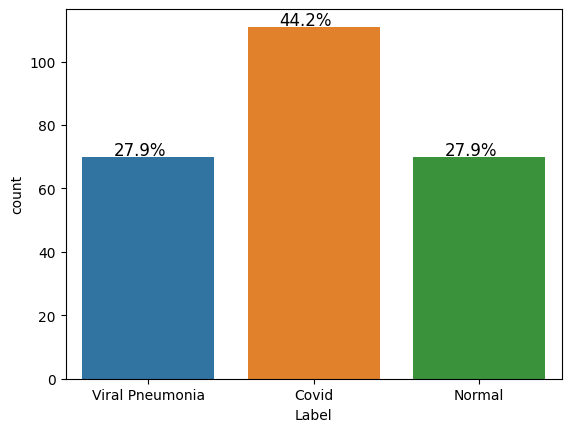

In [11]:
# Plot the distribution of the class label
def bar_plot(data, feature):
    # Creating the countplot
    plot = sns.countplot(x = feature, data = data)

    # Finding the length the whole data
    total = len(data)

    # Creating the percentages to each label in the data
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y),ha="center",
            va = "center",
            size = 12,
            xytext = (0, 5),
            textcoords = "offset points")
    plt.show()

bar_plot(label_data,'Label')

In [12]:
label_data['Label'].value_counts()

Covid              111
Viral Pneumonia     70
Normal              70
Name: Label, dtype: int64

### Data Preprocessing:

In [13]:
# Normalizing images:
image_data_norm = image_data / 255.0

In [14]:
image_data_norm[0]

array([[[0.0627451 , 0.0627451 , 0.0627451 ],
        [0.12156863, 0.12156863, 0.12156863],
        [0.15294118, 0.15294118, 0.15294118],
        ...,
        [0.10588235, 0.10588235, 0.10588235],
        [0.2       , 0.2       , 0.2       ],
        [0.3254902 , 0.3254902 , 0.3254902 ]],

       [[0.09019608, 0.09019608, 0.09019608],
        [0.08235294, 0.08235294, 0.08235294],
        [0.16078431, 0.16078431, 0.16078431],
        ...,
        [0.95686275, 0.95686275, 0.95686275],
        [0.9254902 , 0.9254902 , 0.9254902 ],
        [0.2627451 , 0.2627451 , 0.2627451 ]],

       [[0.07058824, 0.07058824, 0.07058824],
        [0.12156863, 0.12156863, 0.12156863],
        [0.14509804, 0.14509804, 0.14509804],
        ...,
        [0.31372549, 0.31372549, 0.31372549],
        [0.27058824, 0.27058824, 0.27058824],
        [0.22745098, 0.22745098, 0.22745098]],

       ...,

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0

In [16]:
# Label Encoding:
le = LabelEncoder()
new_label = le.fit_transform(label_data.values)
new_label_df = pd.DataFrame(new_label, columns=['Label'])
new_label_df

,Label
0,2
1,2
2,2
3,2
4,2
...,...
246,1
247,1
248,1
249,1


In [17]:
new_label_df['Label'].unique()

array([2, 0, 1])

In [18]:
unique_label = label_data['Label'].unique()
unique_label

array(['Viral Pneumonia', 'Covid', 'Normal'], dtype=object)

## Model Building:

In [19]:
y = new_label_df['Label']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(image_data_norm, y, stratify=y, test_size=0.2, random_state=42)

In [21]:
y_train.value_counts()

0    88
1    56
2    56
Name: Label, dtype: int64

In [22]:
y_test.value_counts()

0    23
1    14
2    14
Name: Label, dtype: int64

In [23]:
X_train.shape

(200, 128, 128, 3)

In [57]:
# Define Model Architecture
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (128,128,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 64)       

In [65]:
model.fit(X_train, to_categorical(y_train), epochs=50, batch_size=32, validation_data=(X_test, to_categorical(y_test)))

Epoch 1/50
7/7 [==============================] - 14s 180ms/step - loss: 1.1130 - accuracy: 0.4200 - val_loss: 1.0467 - val_accuracy: 0.4510
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 1.0204 - accuracy: 0.5700 - val_loss: 0.9211 - val_accuracy: 0.4510
Epoch 3/50
7/7 [==============================] - 0s 21ms/step - loss: 0.7717 - accuracy: 0.6600 - val_loss: 0.5909 - val_accuracy: 0.7451
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 0.5907 - accuracy: 0.6950 - val_loss: 0.3516 - val_accuracy: 0.8824
Epoch 5/50
7/7 [==============================] - 0s 22ms/step - loss: 0.3813 - accuracy: 0.8500 - val_loss: 0.2223 - val_accuracy: 0.9216
Epoch 6/50
7/7 [==============================] - 0s 22ms/step - loss: 0.2821 - accuracy: 0.8950 - val_loss: 0.1722 - val_accuracy: 0.9020
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 0.2485 - accuracy: 0.9050 - val_loss: 0.8214 - val_accuracy: 0.7843
Epoch 8/50
7/7 [=========

## Transfer Learning with vgg16:

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16

In [77]:
# define VGG16
base_model = VGG16(include_top=False,input_shape = (128,128,3), weights='imagenet',)

# Freezing the layers because we need just the weights and not the layers.
for layer in base_model.layers:
    layer.trainable = False

# Define the Architecture:
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation = 'softmax'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              8389632   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 3)                 3075      
                                                                 
Total params: 23107395 (88.15 MB)
Trainable params: 8392707 (32.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [79]:
# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_path = '/content/drive/MyDrive/MLOps Class/Model'
checkpoint4 = ModelCheckpoint(os.path.join(model_path, 'model_vgg3.hdf5'),save_best_only=True, verbose=1)
es = EarlyStopping(patience=3)

In [80]:
history2 = model2.fit(X_train, to_categorical(y_train), epochs=50, batch_size=32, validation_data=(X_test, to_categorical(y_test)), callbacks=[checkpoint4, es])

Epoch 1/50
6/7 [========================>.....] - ETA: 0s - loss: 2.6770 - accuracy: 0.4531
Epoch 1: val_loss improved from inf to 0.45288, saving model to /content/drive/MyDrive/MLOps Class/Model/model_vgg3.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 3s 204ms/step - loss: 2.5740 - accuracy: 0.4750 - val_loss: 0.4529 - val_accuracy: 0.8235
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.8050
Epoch 2: val_loss improved from 0.45288 to 0.23374, saving model to /content/drive/MyDrive/MLOps Class/Model/model_vgg3.hdf5
7/7 [==============================] - 5s 746ms/step - loss: 0.5310 - accuracy: 0.8050 - val_loss: 0.2337 - val_accuracy: 0.9020
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.9200
Epoch 3: val_loss improved from 0.23374 to 0.05796, saving model to /content/drive/MyDrive/MLOps Class/Model/model_vgg3.hdf5
7/7 [==============================] - 1s 153ms/step - loss: 0.2684 - accuracy: 0.9200 - val_loss: 0.0580 - val_accuracy: 1.0000
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9200
Epoch 4: val_loss improved from 0.05796 to 0.05594, saving model to /content/drive/MyDr

In [82]:
def model_performance(figsize,model_name,history1,label1,history2,label2,title,xlabel,ylabel,epoch):
    plt.figure(figsize=(figsize))
    plt.plot(model_name.history[history1], label=label1)
    plt.plot(model_name.history[history2], label=label2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(0,epoch,2),range(1,(epoch+1),2))
    plt.grid(linestyle='--',linewidth=0.4)
    plt.legend()
    plt.show()
    return

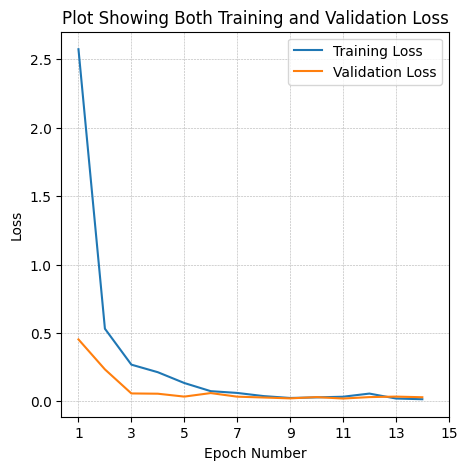

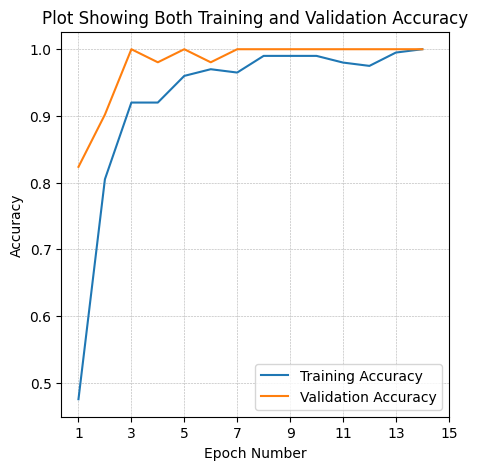

In [83]:
#Plotting Training and Validation loss:
model_performance(figsize=(5,5),model_name=history2,history1='loss',label1='Training Loss',history2='val_loss',
                  label2='Validation Loss',title='Plot Showing Both Training and Validation Loss',
                  xlabel='Epoch Number',ylabel='Loss',epoch=15)

#Plotting Training and Validation Accuracies:
model_performance(figsize=(5,5),model_name=history2,history1='accuracy',label1='Training Accuracy',
                  history2='val_accuracy',label2='Validation Accuracy',
                  title='Plot Showing Both Training and Validation Accuracy',xlabel='Epoch Number',
                  ylabel='Accuracy',epoch=15)

In [84]:
def building_model(model,test_data):
    #model.fit(Xtrain_data,Ytrain_data)
    y_pred_ = model.predict(test_data)
    y_pred = np.argmax(y_pred_, axis=1)
    return y_pred


def classification_confusion_matrix(fig,yTest,yTrain,yPrediction_train, yPrediction_test,display_labels):
    print('Classification Report for Training:')
    print(classification_report(yTrain, yPrediction_train))
    print('='*80)
    print('Classification Report for Testing:')
    print(classification_report(yTest, yPrediction_test))
    print('='*80)
    fig, ax = plt.subplots(1,2,figsize=fig)
    ConfusionMatrixDisplay.from_predictions(yTrain,yPrediction_train, display_labels=display_labels,ax=ax[0])
    ConfusionMatrixDisplay.from_predictions(yTest,yPrediction_test, display_labels=display_labels,ax=ax[1])
    ax[0].title.set_text('Training')
    ax[1].title.set_text('Testing')
    plt.show()
    return

In [ ]:
# Defining class label names:
class_list = []
for class_ in list(train_generator.class_indices.keys()):
    if class_ == 'Brain Tumor':
        class_list.append('Tumor')
    else:
        class_list.append('No Tumor')
class_list

2/2 [==============================] - 0s 40ms/step
Classification Report for Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        56

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Classification Report for Testing:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



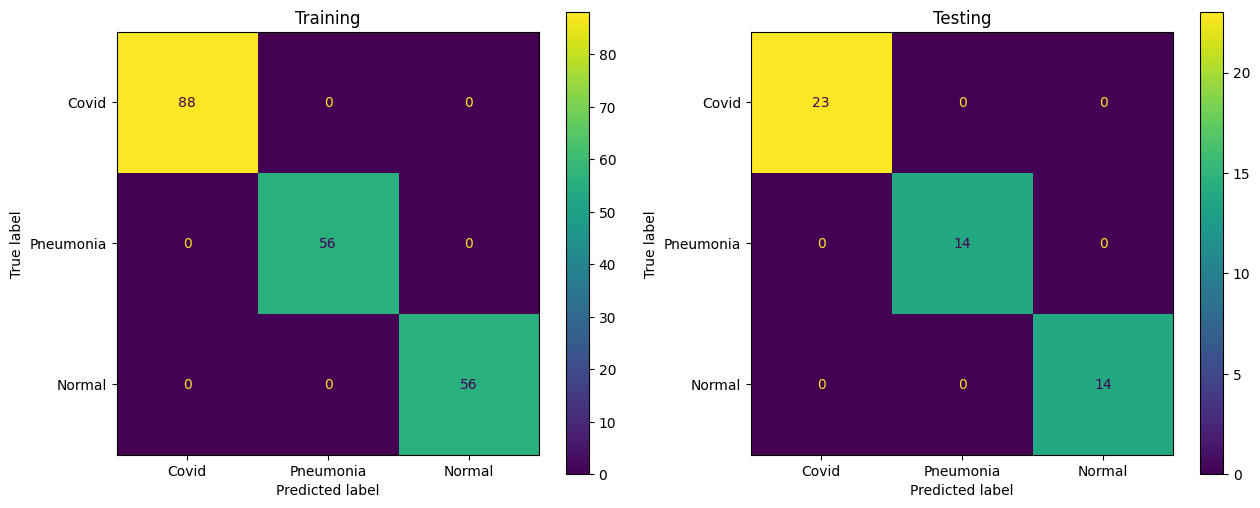

In [89]:
# Model performance Evaluation:
model_saved = load_model('/content/drive/MyDrive/MLOps Class/Model/model_vgg3.hdf5')

#Training Prediction:
prediction_train = building_model(model=model_saved,test_data=X_train)

#Testing Prediction:
prediction_test = building_model(model=model_saved,test_data=X_test)

#Confusion Matrix for both Training and Testing:
classification_confusion_matrix(fig=(15,6),yTest=y_test,yTrain=y_train,yPrediction_train=prediction_train,
                                yPrediction_test=prediction_test,display_labels=['Covid', 'Pneumonia', 'Normal'])